In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy
import re
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



### Reading data into Pandas
I decided to read the most frequent csv dataset for this project. The data is from teh 2014-2015 school year

In [302]:
df = pd.read_csv("Desktop/CollegeScorecard_Raw_Data/MERGED2011_12_PP.csv")

### Preprocessing round 1
- remove features with only null values
- remove features with only 1 value across all obs
- turn certain features values into the string values that they represent (ie. `HIGHDEG`) is suppose to represent the highest degree awarded

In [303]:
def drop_svf(df):
    '''
    drop single value features (where all observations in that column have only 1 value)
    df : dataframe 
    return : dataframe
    '''
    df_cleaned = deepcopy(df)
    for column in df.columns:
        if len(df[column].value_counts()) == 1:
            df_cleaned = df_cleaned.drop(column, axis = 1)
    return df_cleaned

def replace_category(df, col_name, name_key):
    '''
    replace the integer/float representation of values in a column 
    by the corresponding string values of name_key
    
    df : dataframe to operate on
    col_name : a list of column names of which the replacement will take place
    name_key : the corresponding replacement list of strings to which each of the values 
               in col_name will be replaced by
               
    return : the newly modified dataframe
    '''
    new_df = df.copy()
    for col in col_name:
#         assert str(df[col].dtype) == 'float64' or str(df[col].dtype) == 'int64'
        new_col = []
        for i,obs in enumerate(df[col]):
            if np.isnan(obs):
                str_val = np.nan
            else:
                str_val = name_key[int(obs)]
            new_col.append(str_val)
        new_df[col] = new_col
    return new_df

In [304]:
df = df.dropna(axis = 1, how='all')
df = drop_svf(df)
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,3.0,1,1,...,NaN,0.000000,1088.0,NaN,NaN,1,0.4786,0.5214,1514.0,1438.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3.0,1,1,...,NaN,0.283168,1515.0,NaN,NaN,1,0.4154,0.5846,2836.0,3160.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,3.0,1,1,...,NaN,0.000000,4.0,NaN,NaN,1,0.4389,0.5611,315.0,266.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,3.0,1,1,...,NaN,0.348243,626.0,NaN,NaN,1,0.5402,0.4598,1083.0,1208.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,3.0,1,1,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4054,0.5946,2045.0,1957.0


In [306]:
deg_name = ['not classified','certificate','associate','bachelor','graduate']
control_name = ['','public', 'private_nonprofit', 'private_for-profit']
region_name = ['us_service_schools', 'new_england', 'mid_east', 'great_lakes', 'plains',
               'southeast', 'southwest', 'rocky_mountains', 'far_west', 'outlying_areas']
iclevel_name = ['','4_year','2_year','less_than_2_year']

# df = replace_category(df, ['HIGHDEG','PREDDEG'], deg_name)
# df = replace_category(df, ['CONTROL'], control_name)
# df = replace_category(df, ['REGION'], region_name)
# df = replace_category(df, ['ICLEVEL'], iclevel_name)



### College University subset (Preprocessing round 2)

- I am going to begin my analysis first with schools that have undergraduate students enrolled
- I am going to drop certian redundant and unnecessary features (mostly names, zip codes, ids)
- I am going to drop observation with more than 40% null values to insure quaity of our observations when we impute missing features later


In [307]:
def remove_row_missing(df, threshold):
    '''
    remove observations in df that has more than threshold% of null values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an observation
    
    return : a new dataframe with observations dropped
    '''
    new_df = df.copy()
    length = len(df.columns)
    
    for i, row in df.iterrows():
        num_nans = row.isnull().sum()
        
        ratio = num_nans / length
        
        if ratio > threshold:
            new_df.drop(i, inplace = True)
            
    return new_df.reset_index(drop=True)


In [308]:
df_college = df[df.UGDS > 0].reset_index(drop='True')
df_college = df_college.drop(['OPEID','INSTNM','CITY','ZIP','OPEID6','ST_FIPS',
                              'SCH_DEG','STABBR','REPAY_DT_MDN','ALIAS'], axis = 1)
df_college = remove_row_missing(df_college, 0.8)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


In [309]:
df_college.shape

(7042, 1575)

### Deciding on which features to predict
I am going to predict mean income after graduation from these schools. Since I am interested in the longer term mean earnings for graduates, I will be trying to predict `MN_EARN_WNE_P10`. Moreoever, there will generally more variabilty for earnings data the more years after graduation, possibly giving us more interesting results.

- I will then remove all features that are other ways to represent earning information (ie. `MN_EARN_WNE_P6`)  because they are basically the same measure as my target variable.
- I will also remove all information regarding repayment since that is also highly related to our target variable, diminishing the task of this project, which is to use static school information to predict post graduation earnings

In [310]:
# list of column names on earnings that will be removed due to relationship with MN_EARN_WNE_P10
loe = list(df_college.columns[df_college.columns.to_series().str.contains('_EARN_')][1:])
loe.extend(list(df_college.columns[df_college.columns.to_series().str.contains('GT_')]))

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lor = list(df_college.columns[df_college.columns.to_series().str.contains('RPY')])

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lod = list(df_college.columns[df_college.columns.to_series().str.contains('DEBT')])

df_college = df_college.drop(loe, axis = 1)
df_college = df_college.drop(lor, axis = 1)
df_college = df_college.drop(lod, axis = 1)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


### Removing features with too many nulls and privacy supressed columns and replace null values in each column by 0 (Preprocessing round 3)

- I am also going to drop features that have more than 20% missing data as imputation later will be troublesome with so much missing values.
- I am going to replace values in ordinal features will with 0 and create another binary value feature right after it indicating whether whether the corresponding value in the previous feature has nan.

For categorical variables I can do the same because having null value for that observation inidicates the absence of its categorical quality, which is itself a category, a quality.

In [311]:
def remove_col_missing(df, threshold):
    '''
    remove features in df that has more than threshold% of null values + privacy suppressed values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an features
    
    return : a new dataframe with features dropped
    '''
    new_df = df.copy()
    length = len(df)
    
    for col in list(df.columns):
        num_nans = df[col].isnull().sum()
        ps = list(df[col]).count('PrivacySuppressed')
        
        ratio = (num_nans + ps) / length
        
        if ratio > threshold and col != 'MN_EARN_WNE_P10':
            new_df.drop(col, axis = 1, inplace = True)
            
    return new_df.reset_index(drop=True)


# let us create the binary features first
def create_null_indicator(df):
    '''
    for every column in the dataframe with null values in it, create another 0/1 binary column 
    right after it indicating whether the corresponinf row obs in the previous column is null
    
    df : a dataframe
    return : a dataframe with additional columns created
    '''
    new_df = df.copy()
    
    for i in range(len(df.columns)):
        
        if not df[df.columns[i]].isnull().values.any():
            continue
            
        null_indicator = []
        
        for obs in df[df.columns[i]]:
            # np.nan == np.nan will yield false
            if obs == obs:
                null_indicator.append(0)
            else:
                null_indicator.append(1)
                
        col_name = str(df.columns[i]) + '_ISNULL'
        index = list(new_df.columns).index(df.columns[i])
        
        new_df.insert(index + 1, column = col_name, value = np.array(null_indicator))
    return new_df

In [312]:
df_college = remove_col_missing(df_college, 0.6)
df_college = create_null_indicator(df_college)
df_college.fillna(0, inplace=True)


### Writing out file for imputation

In [317]:
df_college.to_csv('df_college3.csv',index=False,)

### Privacy suppressed columns

After dealing with the null values, we still have privacy suppressed values in the dataset to handle. However, for these values, we can be sure that they exist but has been suppressed due to privacy issues usally for small schools with less people. Therefore, imputing them would be more acceptable than imputing missing values where we are not even able to determine whether its missing or do not apply

I applied Multiple Imputation Chained Equation on the dataset for privacy suppressed value. SInce python does not have a good enough imputation package that support this method, I did the imputation in R. Now I am reading back the 5 completed imputed dataset into pandas

In [100]:
chunks = pd.read_csv('imputed3.csv',chunksize=7042,)

In [101]:
completed_dfs = []
for chunk in chunks:
    completed_dfs.append(pd.DataFrame(chunk).reset_index(drop=True))
completed_dfs = completed_dfs[1:]

### Remove some collinear features

When I was runnign the imputation in R, part of what the algorithm did was to drop features in teh imputation process that it deemed strongly collinear to one of the other features. Therefore, certain features still have NAs in them. We will take adavantage of this singal indicating that the correspoding feature is collinear to some other feature and can therefore be dropped without sacrificing our modeling power later on.

In [102]:
def remove_collinear_col(dfs):
    '''
    remove columns in all dataframe that has null values in them
    
    dfs : list of dataframes
    return : list of dataframes with null columns removed
    '''
    new_imputed_dfs = []
    for df in dfs:
        new_df = df.copy()
        for col in df.columns:
            if df[col].isnull().values.any():
                new_df.drop(col, axis = 1, inplace = True)
                try:
                    new_df.drop(col + '_ISNULL', axis = 1, inplace = True)
                except ValueError: # the column had no null values, which is fine
                    pass
        new_imputed_dfs.append(new_df)
                
    return new_imputed_dfs

def remove_missing_target(dfs):
    new_dfs = []
    for df in dfs:
        new_df = df.copy()
        new_df = new_df.drop('MN_EARN_WNE_P10_ISNULL', axis = 1,)
        new_df = df[df['MN_EARN_WNE_P10'] != 0]
        new_dfs.append(new_df)
    return new_dfs

In [103]:

dfs = remove_collinear_col(completed_dfs)

remove the 'ISNNULL' column for the target variable along with observations that has null in target variable

In [104]:
dfs = remove_missing_target(dfs)


### Turn each categorical feature into its own column of 0/1 binary indicator
features such as `PREDDEG1`, `HIGHDEG`, `CONTROL` etc. are categorical variable, so we are goign to use patsy to turn them into multiple binary columns

In [105]:
import patsy

In [106]:
def binarify(df, col_name,):
    '''
    transform the categorical column specified by col_name in df into a binary column for each of the categories
    
    df : dataframe
    col_name : list of categorical colum names in df that are to be transformed
    '''
    new_df = df.copy()
    
    for name in col_name:
        col_position = list(new_df.columns).index(name)
        
        binarified = patsy.dmatrix(name,data=df,return_type='dataframe').drop(['Intercept',], axis = 1)
        
        for i,category in enumerate(binarified):
            new_df.insert(col_position + i + 1, category, binarified[category])
            
        new_df = new_df.drop([name], axis = 1,)
            
    return new_df

In [107]:
categorical = ['PREDDEG','HIGHDEG','CONTROL','REGION','ICLEVEL']
dfs = [binarify(df,categorical) for df in dfs]

### Averaging the imputations

Because I have 5 complete dataset after the imputation, I am going to average all the values across different dataframes together to get 1 complete dataframe.

I am aware that this approach may slghtly diminish the uncertainty nature of the impuation because nwo I have a point estimate of the privacy suppressed value rather than a handful of them. However, Let us first see how this goes.

In [108]:
from collections import defaultdict

In [109]:
def average_dataframes(dfs):
    '''
    average each cell across multiple dataframes 
    
    dfs : list of dataframe
    return : a dataframe with each cell corrected to the average across all dataframes in dfs (dataframe)
    '''
    col_names = dfs[0].columns[3:]
    num_obs = len(dfs[0])
    lst = []
    for col in col_names:
#         if col in categorical:
#             lst.append(df[col])
#             continue
        col_sum = np.array([0]*num_obs)
        
        for df in dfs:
            col_sum = col_sum + np.array(df[col])
    
        lst.append(col_sum / np.array([len(dfs)]*num_obs))
        
    
    return pd.DataFrame(np.array(lst).T, columns=col_names)
        

In [110]:
df_college = average_dataframes(dfs)

In [111]:
intercept = np.array([1]*len(dfs[0]))
df_college.insert(0, 'INTERCEPT',value = intercept)

### Machine Learning package imports

In [112]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

### Standardizing our predictors
This will be quite important if we decide to run a regression. Furthermore, I am goign to log transform the target variable as current literature have consistently shown that Earning data are usually log normal

In [114]:
def standardize(df, lob):
    '''
    standardize columns that are not binary indicators in the dataframe
    
    df : dataframe
    lob : list of partial matching strings for the features that will not be standardized
    return : a standardized df
    '''
    new_df = df.copy()
    for col in list(df.columns):
        if True in [s in col for s in lob]:
            continue
        else:
            mean = df[col].mean()
            std = df[col].std()
            new_df[col] = (df[col] - mean)/std
    return new_df

In [115]:
standardize(df_college,['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT'])

# Emprically, earnings are typically lognormal
df_college.MN_EARN_WNE_P10 = np.log(df_college.MN_EARN_WNE_P10)

##### Lets take a quick look at the distribution of our target variable after transformation

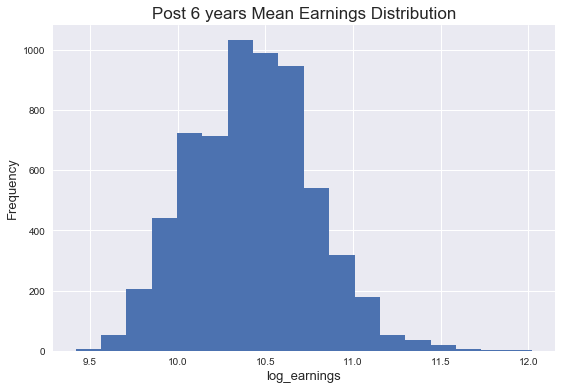

In [116]:
fig, target_hist = plt.subplots(figsize = (9,6))
plt.hist(df_college.MN_EARN_WNE_P10,bins = 18)
plt.title('Post 6 years Mean Earnings Distribution', size = 17)
plt.xlabel('log_earnings', size = 13)
plt.ylabel('Frequency', size = 13)

# roughly normal

### Train test split
I am going to split my dataset into train, test, and validation set first. 

In [117]:
y = df_college.MN_EARN_WNE_P10
X = df_college.drop('MN_EARN_WNE_P10', axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 5555)

### Modeling
Having removed certain collinear variables from the imputation process in R, we still have a relatively large feature space of 435 variables.

We could do a number of things, run a ridge regression to deal with potentially persisting multicollinearity problem that still exists in our dataset   
Please refer :  
http://web.as.uky.edu/statistics/users/pbreheny/764-f11/notes/9-1.pdf

We could also run Lasso for its embedded feature selection methods

In [118]:
def find_alpha(X_train, y_train, n_folds, alphas, l1_ratio = None,):
    '''
    use cross validation method to determine MSE of differnet penalty (alpha) parameters
    in our l2 regularized model.
    
    X_train : feature matrix (dataframe)
    y_train : target_variable (series, np.array, etc..)
    n_folds : number of folds to divide up for cross valdation (int)
    alphas : list of penalty parameter to test out (list)
    return: MSE of different penalty parameters (list)
    '''
    kf = KFold(n=len(X_train), n_folds=n_folds, shuffle=True, random_state=5555)
    alphas=alphas
    all_mse_scores= np.array(len(alphas)*[0.0])

    for train,test in kf:

        X_cv_train= X_train.iloc[train]
        y_cv_train= y_train.iloc[train]
        X_cv_test= X_train.iloc[test]
        y_cv_test= y_train.iloc[test]

        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a, fit_intercept=False, max_iter=1000, tol = 0.004, normalize = True)
            est.fit(X_cv_train,y_cv_train)
            mse = np.mean((np.array((y_cv_test))-est.predict(X_cv_test))**2)
            mse_score.append(mse)
        all_mse_scores += mse_score

    return all_mse_scores/len(alphas)

In [119]:
find_alpha(X_train, y_train, 5, alphas = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,])

# let us use 1e-2 as the penalty parameter for Ridge because it gives the lowest mse

array([ 0.01305524,  0.01305073,  0.01301822,  0.01330054,  0.0138933 ,
        0.01521804,  0.01965238,  0.51358263])

#### Let us define a validation set

In [120]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 5555)

#### Implementing Ridge Regression

In [121]:
# fitting and checking coef with ElasticNet

rcv = RidgeCV(alphas = [1e-2], fit_intercept = True, cv = 10,)
rcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Ridge')
print('MSE: ' + str(np.mean((rcv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(rcv.score(X_valid,y_valid)))

Ridge
MSE: 0.01924151865841799
R2: 0.834520134414


#### Implementing Lasso Regression

In [124]:
# fitting and checking coef with Lasso

lcv = LassoCV(alphas = [1e-6], tol=0.07, fit_intercept = True, max_iter=1000)
lcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Lasso')
print('MSE: ' + str(np.mean((lcv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(lcv.score(X_valid,y_valid)))

Lasso
MSE: 0.02173831637974091
R2: 0.813047310015


#### Implementing ElasticNet

In [123]:
# fitting and checking coef with ElasticNet

encv = ElasticNetCV(l1_ratio=0.5, alphas = [1e-5], fit_intercept = True, tol = 0.1, max_iter=1000)
encv.fit(X_train, y_train)

# scoring our model on our validation set
print('ElasticNet')
print('MSE: ' + str(np.mean((encv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(encv.score(X_valid,y_valid)))

ElasticNet
MSE: 0.021945945207922105
R2: 0.811261671823


#### Random Forest feature selection through feature importance

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [53]:
# Grid searching for optimal parameter

rfr = RandomForestRegressor()

# param_dist = dict(max_depth = [10,30,50,70,100], max_features = ['auto','sqrt'])

# rgs = RandomizedSearchCV(rfr, param_dist, cv=10, scoring='neg_mean_squared_error',) 
# rgs.fit(X_train, y_train,)

print(rgs.best_params_)
print(rgs.best_score_)

NameError: name 'rgs' is not defined

In [125]:
rfr = RandomForestRegressor(n_estimators=120,random_state=5555,)
rffit = rfr.fit(X_train, y_train,)

In [126]:
print('Random Forest')
print('R2: ' + str(rfr.score(X_valid,y_valid)))
print('MSE: ' + str(sum((rfr.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

Random Forest
R2: 0.874684642955
MSE: 0.0145713061358


In [156]:
# top 20 most importan features

feat_importance = sorted(list(zip(X.columns, rfr.feature_importances_)),key=lambda x : x[1], reverse=True)
pprint(feat_importance[:19])

[('ICLEVEL[T.4_year]', 0.18984064663341263),
 ('PCIP12', 0.1541000391399476),
 ('PREDDEG[T.bachelor]', 0.077753615455081984),
 ('MD_FAMINC', 0.069704442236889319),
 ('AVGFACSAL', 0.061094241720201489),
 ('FAMINC', 0.042521343915325978),
 ('PELL_EVER', 0.033439009217565846),
 ('DEP_INC_AVG', 0.025060745395857242),
 ('UGDS_ASIAN', 0.014248692950812155),
 ('INC_PCT_LO', 0.0091328481298068188),
 ('RET_FTL4', 0.0081971511926453109),
 ('INC_PCT_H2', 0.0081448181351887368),
 ('INC_PCT_M2', 0.0081218322238553412),
 ('FEMALE', 0.0067628762738285303),
 ('IND_INC_AVG', 0.0066036010821802086),
 ('MALE_COMP_ORIG_YR8_RT', 0.0062939294299824422),
 ('NOPELL_COMP_ORIG_YR8_RT', 0.0058769794527691955),
 ('NOPELL_COMP_ORIG_YR4_RT', 0.0055046906088528904),
 ('IND_INC_PCT_LO', 0.0051790855595926534)]


### Taking the top features ranked according to feature importance

I want to do some inference with regards to the explanatory power of the most importan variable in my Random Forest model. I am aware that because tree models are able to capture non-linear relationship, predictors that it deemed important may not be have a linear relationship with the target variable. Therefore, some trnasformation adn tweeking may be required when fine tuning the regression model.

Another potential source of problem is that taking this amount of variable, some of them are highly liekly to be strng correlated with one another, leading us into the trap hole of multicollinearity, inflating our stnadard error, which will 'inaccuratize' the estimated coefficient p-value. Therefore, we need to remove some potentially highly correlated predictor variables before proceeding to model

In [672]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [728]:
def multicollinearity_remover(predictor, target, threshold, wanna_keeps, dont_wanna_keeps):
    '''
    remove predictor variables that have to a variance inflation factor above threshold
    
    predictor : predictor varaibles (matrix, dataframe etc.)
    target : target variable vector (series, list, etc.)
    threshold : a number above which a predictor variable will be deemed highly collinear with other predictor
                and be dropped from final predictor matrix (int,float)
    wanna_keeps : list of column names that you definitely want to keep in the predictor matrix returned, regardless
                  of VIF score
    return : a predictor matrix with highly collinear varaibles dropped
    '''
    vifs = [threshold]
    predictor_c = predictor.copy().drop(dont_wanna_keeps, axis = 1)
    
    model = sm.GLM(target, predictor_c)
    result = model.fit()
    keeps = []
    while list(filter(lambda x : x >= threshold, vifs)):
    
        predictor_name = pd.Series(result.params).index
        current_vifs = []
        for i in range(1,len(predictor_name)):
            vif = variance_inflation_factor(result.model.exog, i)
            current_vifs.append(vif)

        vifs = current_vifs

        # index of variable with highest vif
        max_index = current_vifs.index(max(current_vifs))


        col_name = predictor_name[max_index + 1]
        
        # check if variable in wanna_keep
        if col_name in wanna_keeps:
            col = predictor_c[col_name]
            name = col_name
            keeps.append((name,col))
            
        # remove that variable
        predictor_c = predictor_c.drop(col_name, axis = 1)
        
        # refit model
        model = sm.OLS(target, predictor_c)
        result = model.fit()
    
    # adding wanna_keeps
    for i in range(len(keeps)):
        if keeps[i][0] not in predictor_c.columns:
            predictor_c.insert(i+1,keeps[i][0],keeps[i][1])
            
    return  predictor_c


In [729]:
top20 = list(map(lambda x : x[0], feat_importance[:19]))
top20.insert(0,'INTERCEPT')

In [750]:
top20_cleaned = (multicollinearity_remover(
    standardize(X_train[top20],['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT']),
    y_train,
    2,
    ['FAMINC','AVGFACSAL',],
    ['RET_FTL4','INC_PCT_M2','INC_PCT_H2','NOPELL_COMP_ORIG_YR8_RT','NOPELL_COMP_ORIG_YR4_RT','MALE_COMP_ORIG_YR8_RT']))

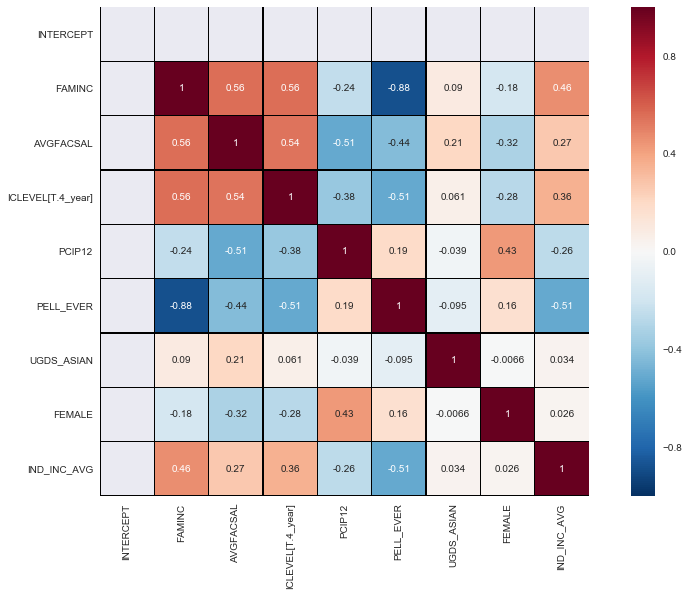

In [751]:
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(top20_cleaned.corr(method = 'pearson'), linewidths=0.25,vmax=1.0, square=True, linecolor='black', annot=True)

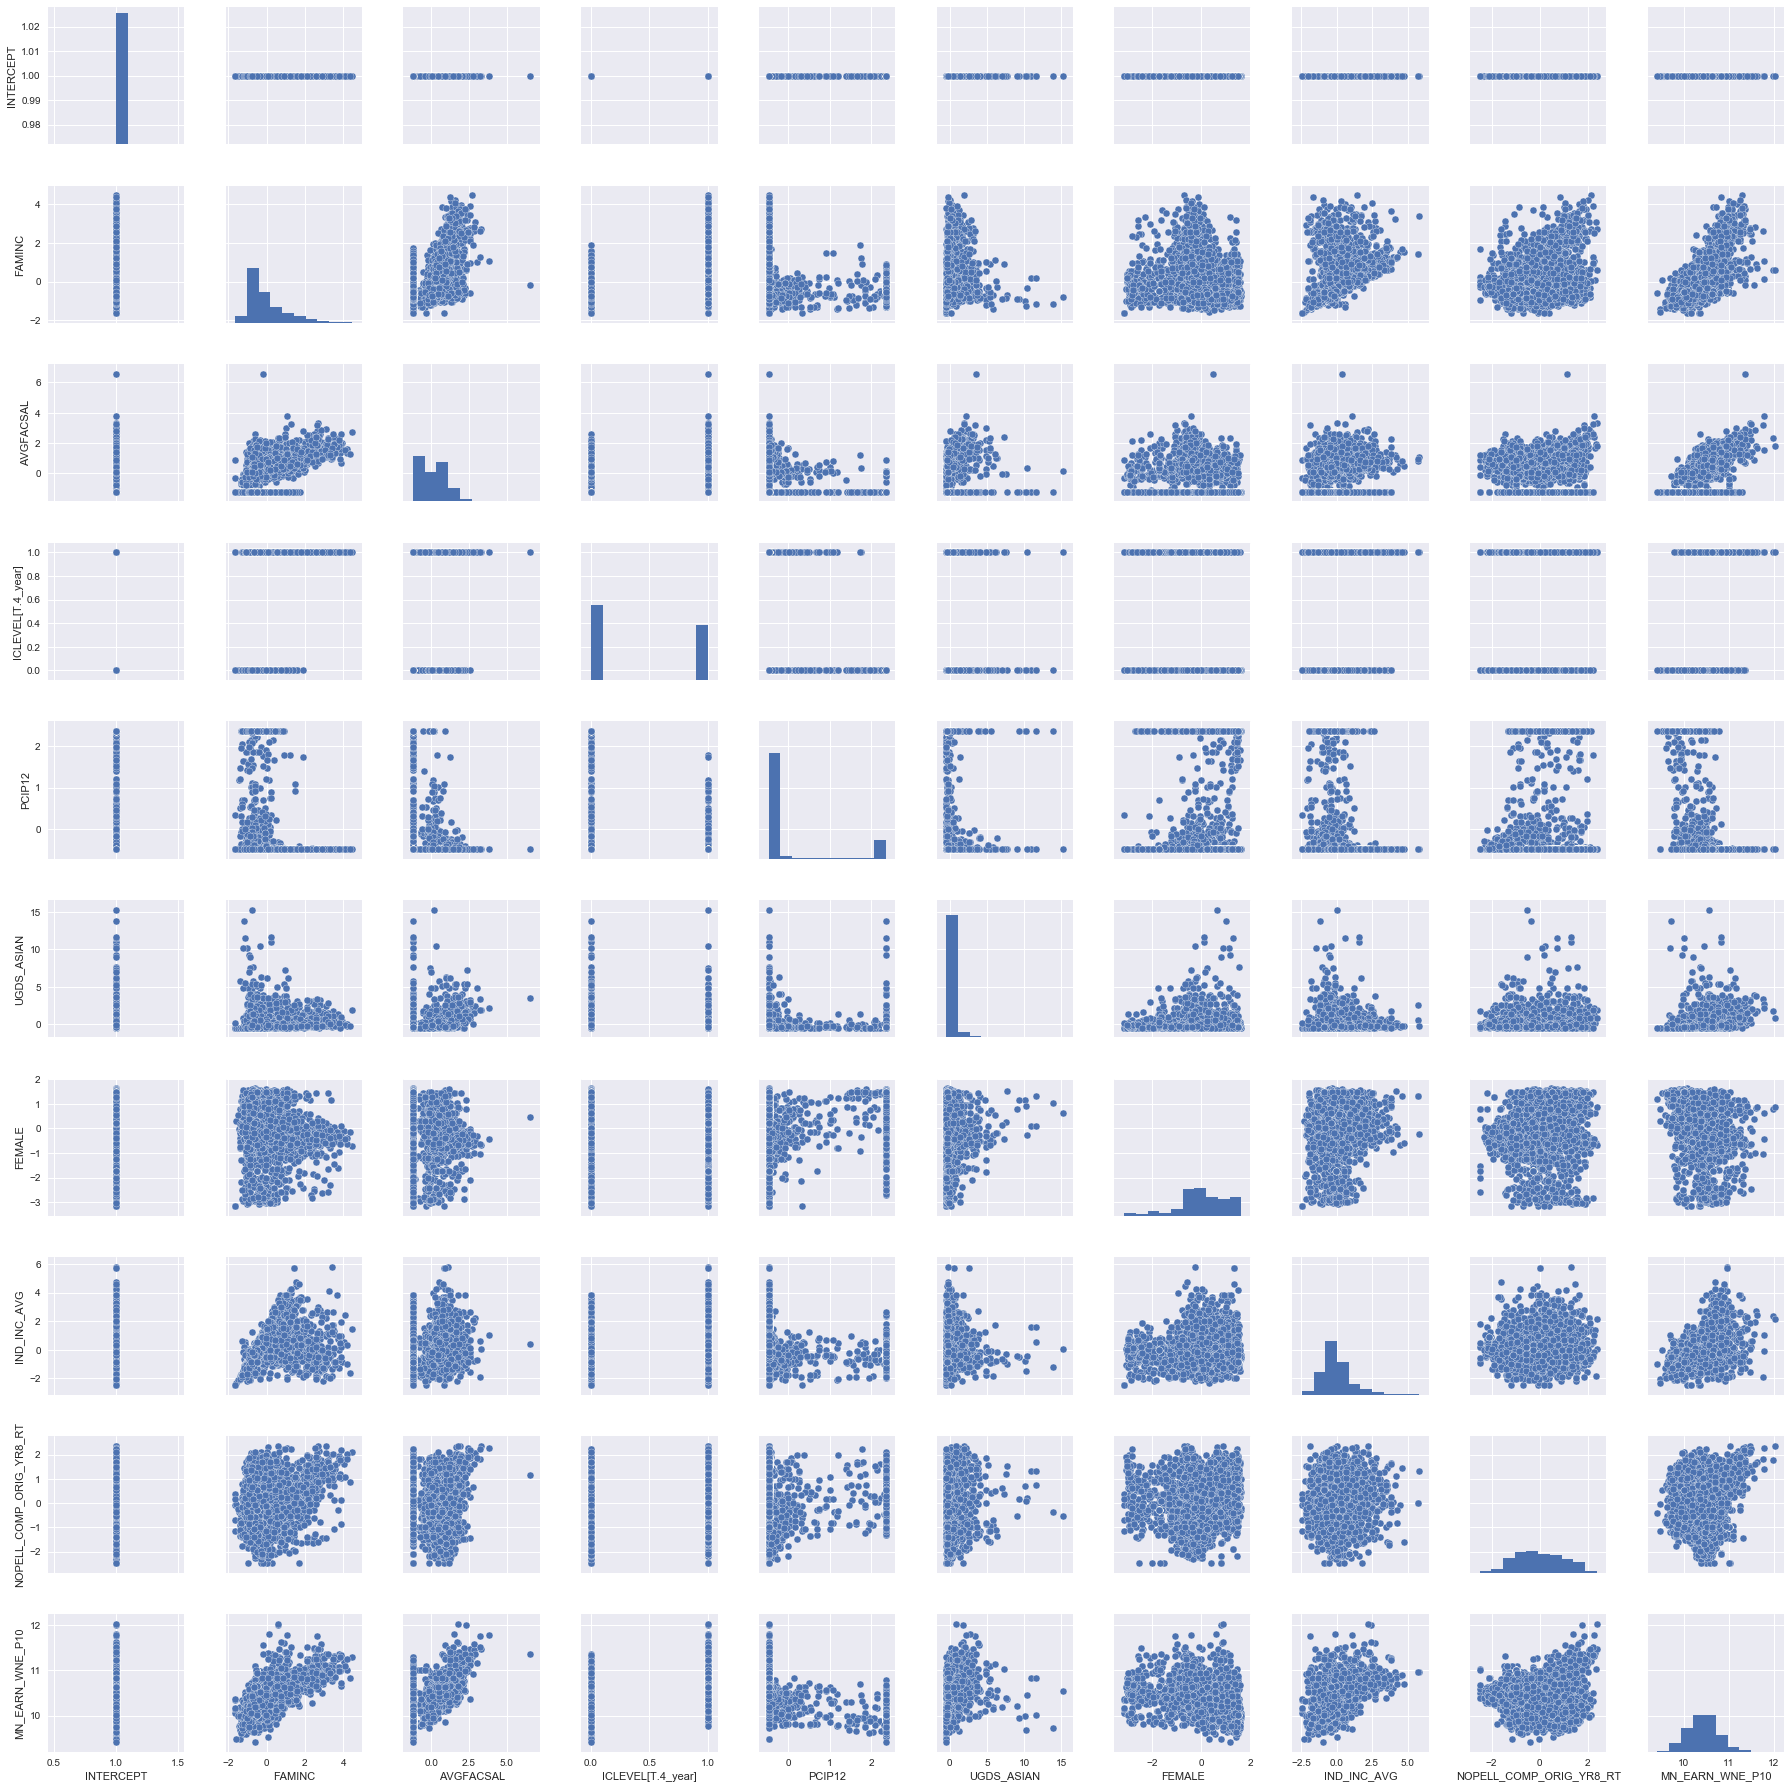

In [705]:
sns.pairplot(pd.concat([top20_cleaned,y_train],axis = 1))

In [775]:
regressor = (pd.concat([top20_cleaned, X_train.AVGFACSAL_ISNULL, X_train.FAMINC_ISNULL,], axis = 1,))

regressor.insert(11,'INTER(FAMINC,IND_INC_AVG)',X_train.FAMINC*X_train.IND_INC_AVG,)
regressor.insert(12,'INTER(FAMINC,PELL_EVER)',X_train.FAMINC*X_train.PELL_EVER,)
regressor.insert(13,'INTER(PELL_EVER,IND_INC_AVG)',X_train.IND_INC_AVG*X_train.PELL_EVER,)
regressor.insert(13,'INTER(PELL_EVER,IND_INC_AVG,FAMINC)',X_train.IND_INC_AVG*X_train.PELL_EVER*X_train.FAMINC,)

regressor.insert(14,'INTER(AVGFACSAL,PCIP12)',X_train.AVGFACSAL*X_train.PCIP12,)
# regressor.insert(15,'INTER(AVGFACSAL,ICLEVEL[T.4_year])',X_train.AVGFACSAL*X_train['ICLEVEL[T.4_year]'],)


In [776]:
lr = sm.OLS(y_train, regressor)
result = lr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MN_EARN_WNE_P10   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     735.2
Date:                Sun, 03 Sep 2017   Prob (F-statistic):               0.00
Time:                        11:49:40   Log-Likelihood:                 1276.5
No. Observations:                3521   AIC:                            -2521.
Df Residuals:                    3505   BIC:                            -2422.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
INTERCEPT                              10.4016      0.110     94.218      0.000      10.185      10.618
FAMINC                                  0.1054      0.027      3.859      0.000       0.052       0.159
AVGFACSAL                               0.1143      0.007     16.970      0.000       0.101       0.128
ICLEVEL[T.4_year]                       0.1058      0.008     13.305      0.000       0.090       0.121
PCIP12                                 -0.0913      0.004    -22.514      0.000      -0.099      -0.083
PELL_EVER                              -0.0600      0.020     -2.953      0.003      -0.100      -0.020
UGDS_ASIAN                              0.0343      0.003     11.386      0.000       0.028       0.040
FEMALE                                 -0.0517      0.003    -15.301      0.000      -0.058      -0.045
IND_INC_AVG                             0.2274      0.037      6.115      0.000       0.154       0.300
AVGFACSAL_ISNULL                        0.1513      0.014     10.907      0.000       0.124       0.179
FAMINC_ISNULL                           0.0207      0.139      0.148      0.882      -0.253       0.294
INTER(FAMINC,IND_INC_AVG)            8.797e-12   4.69e-11      0.188      0.851   -8.32e-11    1.01e-10
INTER(FAMINC,PELL_EVER)              7.794e-06   1.72e-06      4.530      0.000    4.42e-06    1.12e-05
INTER(PELL_EVER,IND_INC_AVG,FAMINC) -8.087e-10   7.31e-11    -11.066      0.000   -9.52e-10   -6.65e-10
INTER(AVGFACSAL,PCIP12)              2.852e-05   8.47e-06      3.366      0.001    1.19e-05    4.51e-05
INTER(PELL_EVER,IND_INC_AVG)         1.189e-05   4.97e-06      2.390      0.017    2.14e-06    2.16e-05
==============================================================================
Omnibus:                      365.991   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              827.510
Skew:                           0.630   Prob(JB):                    2.04e-180
Kurtosis:                       5.013   Cond. No.                     7.97e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.97e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Residual Plot, zero centered, generally homoskedastic

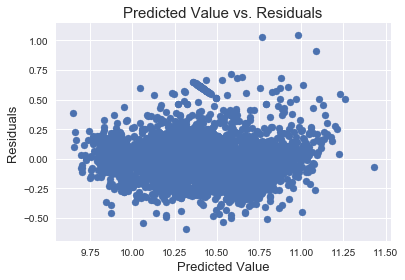

In [714]:
plt.scatter(result.predict(regressor), result.resid)
plt.title('Predicted Value vs. Residuals', size = 15)
plt.xlabel('Predicted Value', size = 13)
plt.ylabel('Residuals', size = 13)